In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm

In [8]:
# 1. Tiền xử lý dữ liệu
# Đọc dữ liệu
df = pd.read_csv(r"C:\Users\Admin\Downloads\energy_dataset.csv")

# Xử lý giá trị thiếu
df = df.drop(columns=['generation hydro pumped storage aggregated'])  # Bỏ cột thiếu
df['forecast wind offshore eday ahead'] = df['forecast wind offshore eday ahead'].fillna(0)
df['generation wind offshore'] = df['generation wind offshore'].fillna(0)
df = df.fillna(0)  # Điền các giá trị thiếu còn lại bằng 0

# Trích xuất đặc trưng thời gian
df['time'] = pd.to_datetime(df['time'], utc=True)
df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
df['month'] = df['time'].dt.month
df['day_of_year'] = df['time'].dt.dayofyear

# Chọn các cột đặc trưng
feature_columns = [
    'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas',
    'generation fossil hard coal', 'generation fossil oil', 'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 'generation hydro water reservoir',
    'generation nuclear', 'generation other', 'generation other renewable', 'generation solar',
    'generation waste', 'generation wind onshore', 'forecast solar day ahead',
    'forecast wind onshore day ahead', 'price actual', 'hour', 'day_of_week', 'month', 'day_of_year'
]
target_column = 'total load actual'

# Chuẩn hóa dữ liệu
scaler_features = StandardScaler()
scaler_target = StandardScaler()
df[feature_columns] = scaler_features.fit_transform(df[feature_columns])
df[target_column] = scaler_target.fit_transform(df[[target_column]])

# Tạo dataset cho Transformer
class TimeSeriesDataset(Dataset):
    def __init__(self, data, feature_columns, target_column, seq_length):
        self.data = data
        self.feature_columns = feature_columns
        self.target_column = target_column
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[self.feature_columns].iloc[idx:idx+self.seq_length].values
        y = self.data[self.target_column].iloc[idx+self.seq_length]  # Lấy giá trị duy nhất
        return torch.tensor(x, dtype=torch.float32), torch.tensor([y], dtype=torch.float32)  # Đảm bảo y là tensor 1D
    
# Tạo dataset và dataloader
seq_length = 24  # Độ dài chuỗi (24 giờ)
dataset = TimeSeriesDataset(df, feature_columns, target_column, seq_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
#2. Định nghĩa mô hình Transformer với đầu ra Gaussian
class GaussianTransformer(nn.Module):
    def __init__(self, feature_dim, seq_length, num_layers=2, nhead=3, hidden_dim=64):
        super(GaussianTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_dim, nhead=nhead, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc_mu = nn.Linear(feature_dim, 1)  # Dự báo trung bình
        self.fc_log_sigma = nn.Linear(feature_dim, 1)  # Dự báo log phương sai

    def forward(self, x):
        # x: (batch_size, seq_length, feature_dim)
        x = x.permute(1, 0, 2)  # (seq_length, batch_size, feature_dim)
        out = self.transformer_encoder(x)
        out = out[-1, :, :]  # Lấy output của bước thời gian cuối
        mu = self.fc_mu(out)
        log_sigma = self.fc_log_sigma(out)
        return mu, log_sigma

#Hàm mất mát Gaussian Negative Log-Likelihood
def gaussian_nll_loss(mu, log_sigma, y):
    sigma = torch.exp(log_sigma)
    return torch.mean(0.5 * torch.log(2 * np.pi * sigma**2) + 0.5 * ((y - mu)**2 / sigma**2))

In [11]:
# 3. Huấn luyện mô hình
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GaussianTransformer(feature_dim=len(feature_columns), seq_length=seq_length).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        mu, log_sigma = model(x)
        loss = gaussian_nll_loss(mu, log_sigma, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 0.624234794658613
Epoch 2, Loss: 0.39644986671144694
Epoch 3, Loss: 0.3043390685522325
Epoch 4, Loss: 0.23172645776332718
Epoch 5, Loss: 0.17339329331322278


In [12]:
# 4. Dự báo
def predict(model, data, seq_length, feature_columns, scaler_target):
    model.eval()
    with torch.no_grad():
        x = torch.tensor(data[feature_columns].iloc[-seq_length:].values, dtype=torch.float32).unsqueeze(0).to(device)
        mu, log_sigma = model(x)
        mu = mu.cpu().numpy()
        sigma = np.exp(log_sigma.cpu().numpy())
        mu = scaler_target.inverse_transform(mu)  # Chuyển về thang gốc
        sigma = scaler_target.inverse_transform(sigma) - scaler_target.mean_  # Điều chỉnh phương sai
        return mu[0, 0], sigma[0, 0]

# Dự báo cho điểm dữ liệu cuối cùng
mu, sigma = predict(model, df, seq_length, feature_columns, scaler_target)
print(f'Dự báo nhu cầu năng lượng: {mu:.2f} ± {sigma:.2f}')

Dự báo nhu cầu năng lượng: 22563.66 ± 1452.96


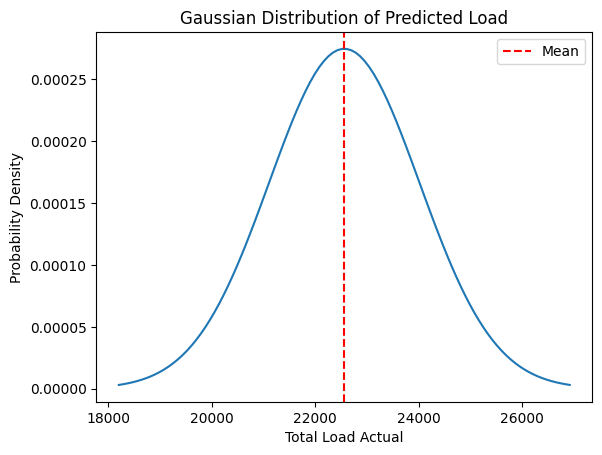

In [14]:
mu, sigma = 22563.66, 1452.96
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma))
plt.axvline(mu, color='r', linestyle='--', label='Mean')
plt.title('Gaussian Distribution of Predicted Load')
plt.xlabel('Total Load Actual')
plt.ylabel('Probability Density')
plt.legend()
plt.show()